In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

from features import *

# Support Vector Regression

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df_typo = df["typology"] # needed for stratification below
# df = pd.get_dummies(df, columns=["language", "canton", "typology"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 54)
y_train.shape = (1756,)
X_test.shape = (440, 54)
y_test.shape = (440,)


## RBF Kernel

In [4]:
categorical_idxs = cols_idxs(df_train.drop(columns="po_value"), categorical_features)
skewed_idxs = cols_idxs(df_train.drop(columns="po_value"), skewed_features)
unskewed_idxs = cols_idxs(df_train.drop(columns="po_value"), unskewed_features)

preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    (PowerTransformer(standardize=True), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

svr = make_pipeline(preprocessor, SVR(kernel="rbf"))
svr.fit(X_train, y_train)
svr_test_pred = svr.predict(X_test)
print("With default params:")
print("SVR (rbf) MAE = {:.3f}".format(mean_absolute_error(y_test, svr_test_pred)))
print("SVR (rbf) R^2 = {:.3f}".format(svr.score(X_test, y_test)))

C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


With default params:
SVR (rbf) MAE = 0.156
SVR (rbf) R^2 = 0.725


In [5]:
parameters = {
    "svr__C": np.logspace(-5, 5, 31),
    "svr__gamma": np.logspace(-10, 0, 11)
}
gcv = GridSearchCV(svr, parameters, scoring = "neg_mean_absolute_error", cv = 5, iid = False, n_jobs=12, verbose=True)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv.best_params_)) # {'svr__C': 4.641588833612772, 'svr__gamma': 0.01}
print("Best MAE = {:.3f}".format(-gcv.best_score_)) #  0.163

Fitting 5 folds for each of 341 candidates, totalling 1705 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    9.8s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   21.3s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   37.4s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:   59.4s
[Parallel(n_jobs=12)]: Done 1705 out of 1705 | elapsed:  3.7min finished
C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Grid search / cross-validation:
Best params = {'svr__C': 21.54434690031882, 'svr__gamma': 0.001}
Best MAE = 0.158


In [6]:
gcv_test_pred = gcv.predict(X_test)
print("On test data:")
print("Tuned SVR MAE = {:.3f}".format(mean_absolute_error(y_test, gcv_test_pred)))
print("Tuned SVR R^2 = {:.3f}".format(r2_score(y_test, gcv_test_pred)))

On test data:
Tuned SVR MAE = 0.149
Tuned SVR R^2 = 0.759


In [7]:
sns.set_style('whitegrid')
def validationcurve_plot(name, param_range, train_scores, valid_scores, ax):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
    ax.set_title("Validation curve for " + name)

    best_idx = valid_scores_mean.argmax()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

In [8]:
svr2 = make_pipeline(preprocessor, SVR(kernel="rbf", gamma=gcv.best_params_["svr__gamma"]))
param_range = np.logspace(-5, 5, 31)
train_scores, valid_scores = validation_curve(svr2, X_train, y_train, param_name="svr__C",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

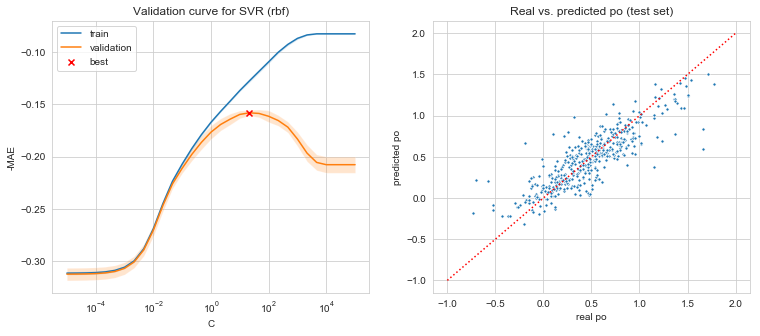

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("SVR (rbf)", param_range, train_scores, valid_scores, ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("-MAE")
sns.scatterplot(y_test, svr_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()